# One-unit neural network model for linear regression

In this notebook, we will use a very simple one-layer, one-node network to perform linear regression.

Admittedly, this is overshooting. There's plenty of linear regression methods out there, and you don't really need neural networks for this kind of problem. However the example serves a two-fold aim:

* to illustrate the core functionality of a neural network unit
* to demonstrate that neural network power emerges from *nonlinearity* (namely, from the activation function)

We'll proceed as follow:

1. download data for a simple regression problem
2. solve the problem with traditional methods (Ordinary Least Squares)
3. solve the problem with a one-unit network

# 0) Loading libraries and setting the random seed

First of all, we load some necessary libraries; then we setup the random seed to ensure reproducibility of results. Since tensorflow uses an internal random generator we need to fix both the general seed (via numpy `seed()`) and tensorflow seed (via `set_seed()`)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
keras.utils.set_random_seed(10)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

# 1) Get the data, split train and validation sets

We are going to use the famous diabetes dataset, conveniently [shipped within the sklearn library](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes).

The dataset has 442 samples (i.e. patients). For each sample we have 10 features (age, sex, blood pressure and so forth). We need to predict a score describing the disease progression. [More info here](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset).

We'll split the dataset in two pieces: 80% for training, 20% for validation. We ask sklearn to normalize all features to save us some time.

In [2]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

#here "scaled=True" is already the default, we write it explicitly just to
#let you know that it's an existing option
X, y = load_diabetes(return_X_y=True, scaled=True)

#to keep nomenclature consistent we'll call the two sets train and validation
#(and not train and test)
#Moreover, we stratify the split so to have the same proportion of male and female
#in the two sets. We happen to know that the second column of the feature dataframe
#encodes sex
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=X[:,1])

Just checking that the split was fine:

In [3]:
print("Train features shape: " + str(X_train.shape))
print("Validation features shape: " + str(X_val.shape))

Train features shape: (353, 10)
Validation features shape: (89, 10)


# 2) Solve with standard linear regression (OLS)

Ordinary Least Squares linear regression fits a linear model minimizing the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [4]:
from sklearn.linear_model import LinearRegression

#train the OLS model on the train set
regressor = LinearRegression().fit(X_train, y_train)

#use the model to predict the validation set. Note that
#here we are not using the y_val variable, which contains
#the ground truth we are actually trying to predict
y_val_pred = regressor.predict(X_val)

Since we are at it, we can also repredict the training set. This will give us a good reference point to evaluate the behaviour of our model. Keep in mind that when you re-predict the training data you are at high risk of overfitting, resulting in highly inflated prediction performances. However, it can still give you information on the model's state.

In [5]:
y_train_pred = regressor.predict(X_train)

Let's plot the predictions against the truth.

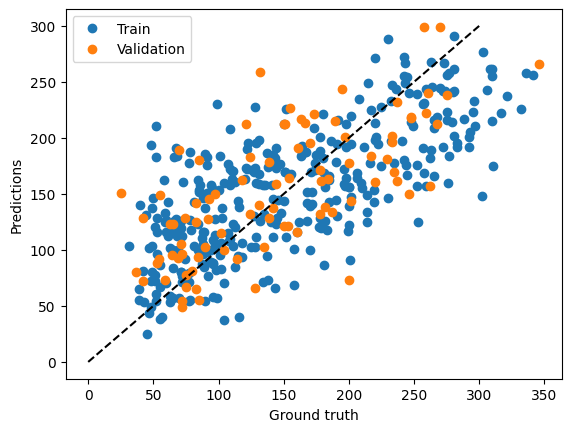

In [6]:
#plotting true vs predicted values
plt.plot(y_train, y_train_pred, 'o', label='Train')
plt.plot(y_val, y_val_pred, 'o', label='Validation')
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

#adding the main diagonal for reference
plt.plot([0, 300], [0, 300], 'k--')

#done
plt.legend()
plt.show()

We can also compute some extra metrics.

In [7]:
from sklearn.metrics import mean_squared_error, r2_score
print(f"Mean squared error: {mean_squared_error(y_val, y_val_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_val, y_val_pred):.2f}")

Mean squared error: 2687.14
Coefficient of determination: 0.47


# 3) Same linear regression, but with one-unit neural network

We'll now solve the exact same problem but using a very simple neural network. To actually produce a linear model we'll remove the activation function, and take the direct output of the unit as the total output of the network. Remember that the problem has 10 features.

In [8]:
from keras import layers

model = keras.Sequential()
model.add(layers.Input(shape=(10,)))
model.add(layers.Dense(1, activation=None))

In the code above the `activation=None` is equivalent to `activation="linear"`. We are telling keras to just output what the node has computed, without any transformation due to the activation function.

It's now time to compile and examine the model.

In [9]:
opt = keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=opt, loss="mse")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11 (44.00 B)

 Trainable params: 11 (44.00 B)

 Non-trainable params: 0 (0.00 B)

The network has 11 parameters: 10 weights for the 10 inputs, plus a bias term.

Let's train it!

In [10]:
h = model.fit(x=X_train, y=y_train, epochs=100, verbose=0, validation_data=(X_val, y_val))

We can examine the evolution of our loss function.

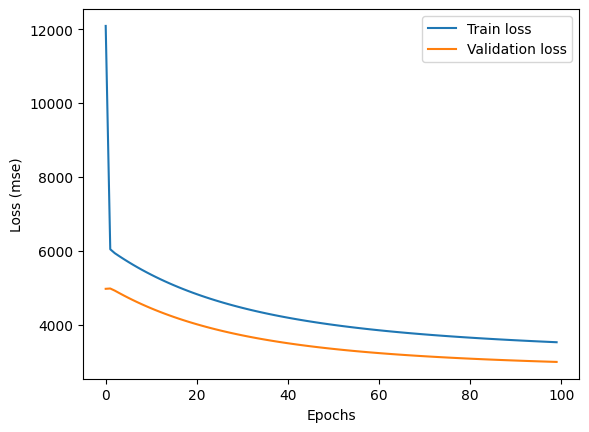

In [11]:
#plotting loss evolution
plt.plot(h.history['loss'], label = 'Train loss')
plt.plot(h.history['val_loss'], label = 'Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (mse)")
plt.legend()
plt.show()

The model learns a lot in the first few epochs, and then slowly improves. If we train it for longer we could maybe squeeze out a little more from it (lower loss, better predictions) but for the scope of the exercise we can stop here.

Let's now predict the validation set (and the train set, for reference) and plot the ground truth vs. our predictions.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


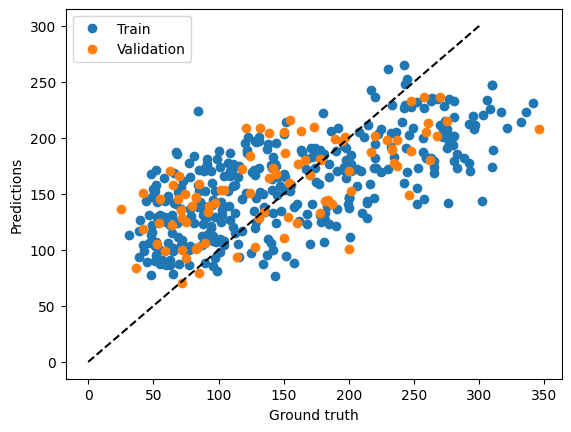

In [12]:
#predicting
y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

#plotting true vs predicted values
plt.plot(y_train, y_train_pred, 'o', label='Train')
plt.plot(y_val, y_val_pred, 'o', label='Validation')
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

#adding the main diagonal for reference
plt.plot([0, 300], [0, 300], 'k--')

#done
plt.legend()
plt.show()

The predictions are a bit skewed: extreme values seem to be predicted closer to the global mean.

Let's compute some metrics on the validation set predictions:

In [13]:
print(f"Mean squared error: {mean_squared_error(y_val, y_val_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_val, y_val_pred):.2f}")

Mean squared error: 2992.74
Coefficient of determination: 0.41


# Conclusions

This notebook showed that a single-unit neural network can be used instead of a traditional regression model like OLS. However, in real cases it's not a good idea to do so. The network requires more computational power, more code, and it's performance are equivalent (at best!) to those of simpler regression models. Neural networks shine on more complex problem, where linear regression is not a viable alternative.